In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
%matplotlib notebook
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import astropy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyOffsetFrame
import astropy.units as u
cosmo = FlatLambdaCDM(H0=75. * u.km / u.s / u.Mpc, Om0=0.31)
c = 299792.458
from ellipsoid import*
from ellipsoid_fit import*
from matplotlib.colors import Normalize

Reading CF4 density, velocity, and associated errors https://projets.ip2i.in2p3.fr//cosmicflows/ https://arxiv.org/abs/2211.16390

In [2]:
hdu = fits.open('CF4gp_new_64-z008_velocity.fits')
hdu_d = fits.open('CF4gp_new_64-z008_delta.fits')
hdu_e = fits.open('CF4gp_new_64-z008_velocity_cube_error.fits')

multiply by 52 the velocity values and associated errors https://projets.ip2i.in2p3.fr//cosmicflows/

In [3]:
t = 52.*hdu[0].data
t_e = 52.*hdu_e[0].data
t_d = hdu_d[0].data
np.shape(t_e)

(64, 64, 64)

This function reads an OBJ file and extracts the vertex, face, and line information. It converts the data into NumPy arrays, making it easier to work with

In [4]:
def load_obj(filename):
    vertices = []
    faces = []
    lines = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                vertices.append(list(map(float, line[2:].strip().split())))
            elif line.startswith('f '):
                face = list(map(int, line[2:].strip().split()))
                faces.append([i-1 for i in face])
            elif line.startswith('l '):
                line = list(map(int, line[2:].strip().split()))
                lines.append([i-1 for i in line])
    return np.array(vertices), np.array(faces), np.array(lines)

Now read the OBJ file for the Laniakea enveloppe: https://sketchfab.com/3d-models/cf4-new-128-z008-watershed-laniakea-b5064f86dcd44277996f758da3cd0349 https://arxiv.org/abs/2305.02339

In [5]:
vertices, faces, lines = load_obj('laniakea.obj')

In [6]:
Lania = pd.DataFrame(vertices, columns=['X','Y','Z'])
Lania

,X,Y,Z
0,-7.8125,0.0000,-62.5000
1,0.0000,0.0000,-62.5000
2,-7.8125,7.8125,-62.5000
3,0.0000,7.8125,-62.5000
4,-7.8125,0.0000,-54.6875
...,...,...,...
3453,-54.6875,-54.6875,187.5000
3454,-46.8750,-54.6875,187.5000
3455,-70.3125,-46.8750,187.5000
3456,-62.5000,-46.8750,187.5000


Given that the velocity field is a 64^3 grid of +/- 500 Mpc/h100. I convert the Laniakea positions to that grid to make it easier to predict velocities for all points at once

In [7]:
u = Lania["X"]
v = Lania["Y"]
w = Lania["Z"]
ii = np.rint(np.round(32. + ((64./1000.)*u),0)).astype(int)
jj = np.rint(np.round(32. + ((64./1000.)*v),0)).astype(int)
kk = np.rint(np.round(32. + ((64./1000.)*w),0)).astype(int)
#that's the Laniakea velocity field
lania_vv = t[:,kk,jj,ii]

Write the positons and velocities as a DataFrame to make it easier to work with

In [8]:
lania_cf4 = pd.DataFrame(np.column_stack((u,v,w,lania_vv[2],lania_vv[1],lania_vv[0])),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4

,SGX,SGY,SGZ,vx,vy,vz
0,-7.8125,0.0000,-62.5000,198.023834,173.473755,-55.513783
1,0.0000,0.0000,-62.5000,198.023834,173.473755,-55.513783
2,-7.8125,7.8125,-62.5000,198.023834,173.473755,-55.513783
3,0.0000,7.8125,-62.5000,198.023834,173.473755,-55.513783
4,-7.8125,0.0000,-54.6875,198.023834,173.473755,-55.513783
...,...,...,...,...,...,...
3453,-54.6875,-54.6875,187.5000,-228.536102,25.211275,222.808090
3454,-46.8750,-54.6875,187.5000,-229.369263,-9.903706,213.526794
3455,-70.3125,-46.8750,187.5000,-274.572876,17.027435,212.022064
3456,-62.5000,-46.8750,187.5000,-274.572876,17.027435,212.022064


In [9]:
lania_cf4.to_csv("new_laniakea_cf4_velocities.csv", index = False, header = True)

The given function ellipsoid_fit(X) is taken from https://github.com/aleksandrbazhin/ellipsoid_fit_python. This function performs an ellipsoid fitting to a set of 3D points represented by the input array X. 

Here's a description and summary of the function:

1. The function takes an input array X containing 3D points, where each row represents a point and each column represents the coordinate in the x, y, and z directions.

2. The function extracts the x, y, and z coordinates from X using slicing and assigns them to variables x, y, and z, respectively.

3. It constructs a matrix D that represents a linear system of equations for fitting an ellipsoid. Each row of D corresponds to an equation involving the x, y, and z coordinates of the points.

4. It calculates the right-hand side of the linear least squares problem (d2) by summing the squared x, y, and z coordinates.

5. The function solves the linear system of equations D.dot(D.T).dot(u) = D.dot(d2) for u, which represents the parameters of the ellipsoid.

6. It calculates the ellipsoid's semi-axis lengths a, b, and c based on the parameters u.

7. The function constructs a matrix A based on the ellipsoid parameters, representing the quadratic form of the ellipsoid equation.

8. It solves a linear system of equations to find the center of the ellipsoid.

9. It constructs a translation matrix to move the ellipsoid's center to the origin.

10. The function applies the translation matrix to A to obtain the rotated ellipsoid.

11. It calculates the eigenvalues and eigenvectors of the rotated ellipsoid's quadratic form matrix.

12. The eigenvalues represent the inverse square radii of the ellipsoid along the principal axes.

13. The eigenvectors represent the directions of the ellipsoid's principal axes.

14. The function scales the radii by the sign of the corresponding eigenvalues and returns the center, eigenvectors, radii, and the ellipsoid parameters.

In summary, this function fits an ellipsoid to a set of 3D points by solving a linear least squares problem and extracting the center, eigenvectors, and radii of the ellipsoid. It provides a way to estimate the shape and orientation of an ellipsoidal structure that best represents the given set of points.

In [10]:
ellipsoid = ellipsoid_fit(vertices)

In [11]:
center = ellipsoid[0]

axes = ellipsoid[2]

R = ellipsoid[1]

The function performs the following steps to check the solution: For more info on this function please have a look here where this function is coming from http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html

1. Subtract the center of the ellipsoid from each point to make the ellipsoid centered at the origin.
2. Create a transformation matrix that will rotate the points so that the bulges of the ellipsoid are aligned with the axes (no xy, xz, or yz terms), and then scale the points by the inverse of the axes gains.
3. Apply the transformation matrix to the points.
4. Calculate the distance from the origin for each point (which should ideally be 1.0). The function then outputs the average radius and standard deviation of the radii of the transformed points, which can be used to evaluate the accuracy of the fitted ellipsoid.
5.In general, a good fit of an ellipsoid to a set of points should result in radii that are close to 1 and a low standard deviation. However, the specific values that can be considered as indicating a good fit depend on the context and the tolerance for errors.

For example, in some applications, a radius within 10% of 1 (i.e., between 0.9 and 1.1) may be considered a good fit. In other applications, a more stringent criterion may be required, such as a radius within 5% of 1 (i.e., between 0.95 and 1.05).

Similarly, the acceptable range of standard deviation may also depend on the context and the required accuracy of the fit. In general, a lower standard deviation indicates a more precise fit. However, what is an acceptable standard deviation can depend on the specifics of the application.

Therefore, the values that indicate a good fit should be determined based on the context and the specific requirements of the application.

In [12]:
check01 = printAns3D(center,axes,R,vertices[:,0],vertices[:,1],vertices[:,2],"True")


Center at     -9.2335,  -47.0633,   85.0857
Axes gains    48.6154,  128.7463,  166.3854 
Rotation Matrix
   0.25957,   0.81427,   0.51922
   0.92221,  -0.36857,   0.11698
  -0.28662,  -0.44847,   0.84660

Transformation Matrix
 [[0.00848546 0.00248008 0.00215182]
 [0.00248008 0.01590222 0.00607978]
 [0.00215182 0.00607978 0.0099593 ]]

Average Radius      0.9723 (truth is 1.0)
Stdev of Radius     0.2339
 


This code generates a 3D plot of an ellipsoid, including the original data points, the fitted ellipsoid surface, the center, and the principal axes. It provides a visualization of the ellipsoid's shape, orientation, and position relative to the original data points.

<IPython.core.display.Javascript object>


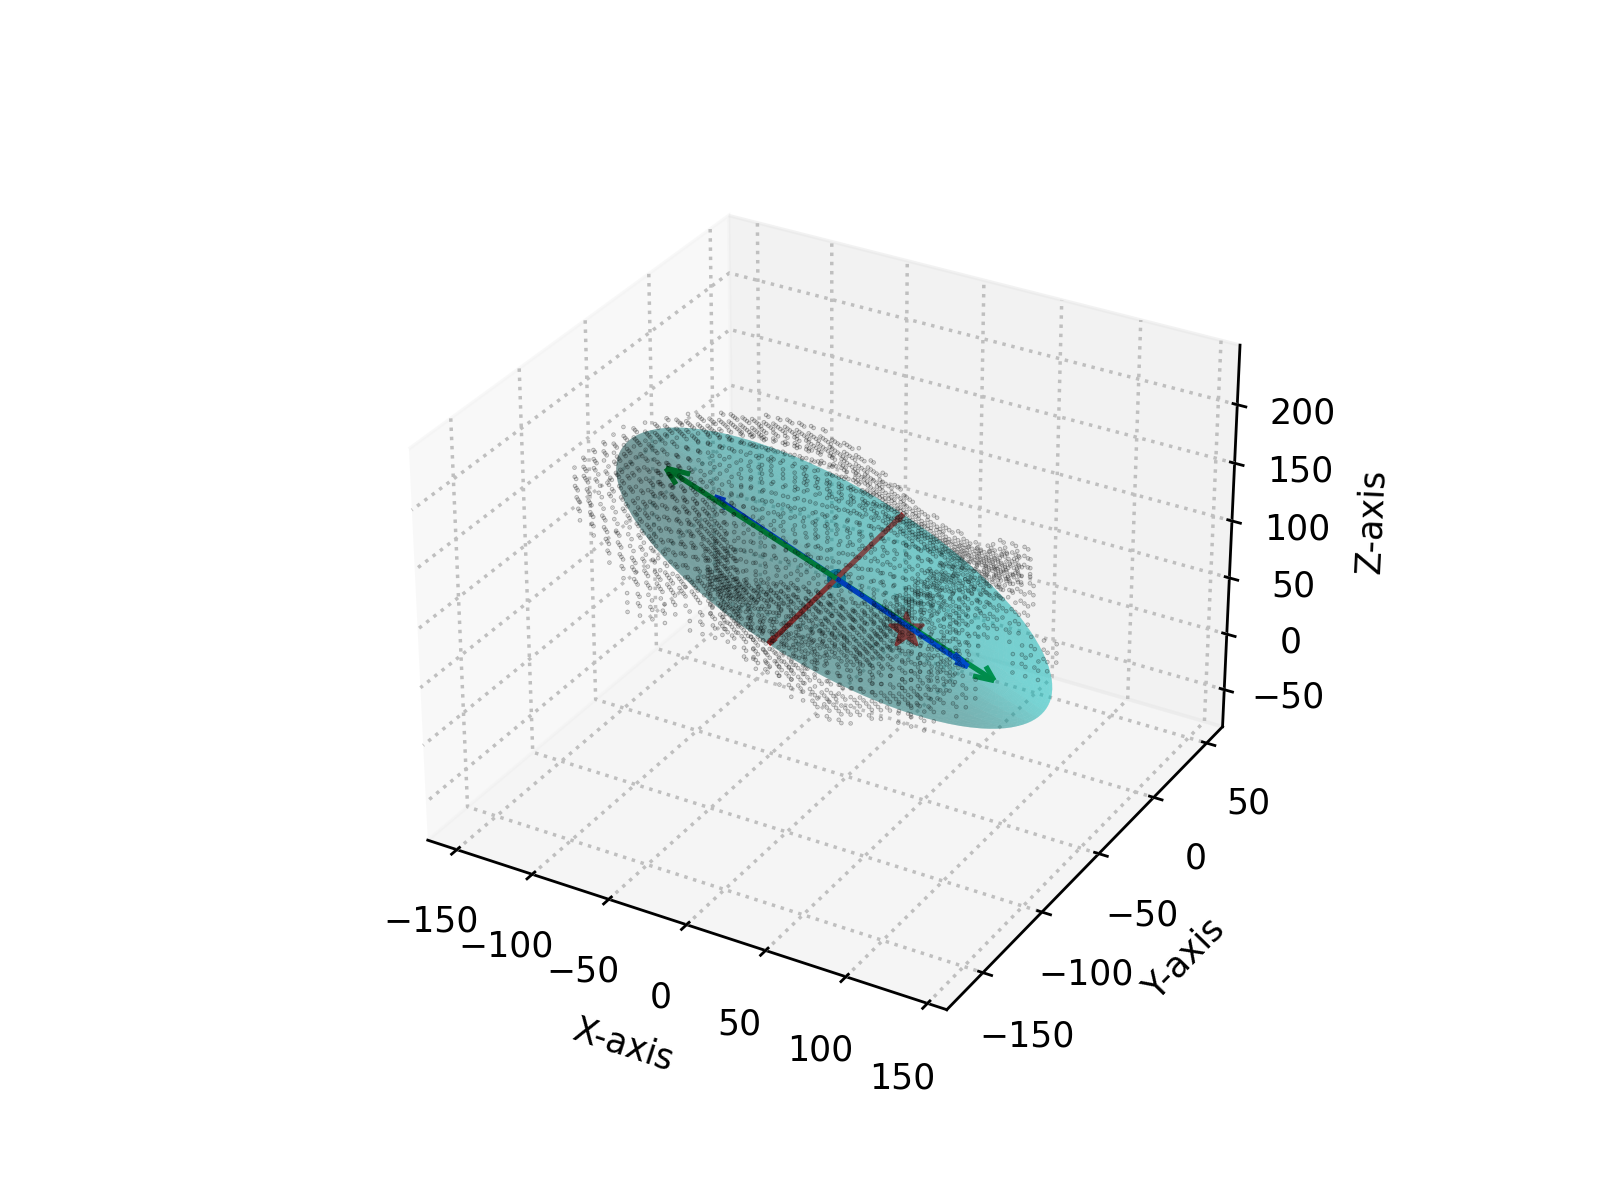

In [13]:
uu = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = axes[0] * np.outer(np.cos(uu), np.sin(vv))
y = axes[1] * np.outer(np.sin(uu), np.sin(vv))
z = axes[2] * np.outer(np.ones_like(uu), np.cos(vv))

for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center
semiaxea= np.dot([axes[0], 0, 0], R)
semiaxeb= np.dot([ 0, axes[1], 0], R)
semiaxec= np.dot([ 0, 0,axes[2]], R)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lania_cf4.SGX,lania_cf4.SGY,lania_cf4.SGZ,s=0.1,alpha=0.3,c='k')
ax.plot_surface(x, y, z, color='c', alpha=0.3)
ax.scatter(center[0],center[1],center[2])
ax.scatter(0,0,0,color="red",marker='*',s=100)
ax.quiver(center[0], center[1], center[2], semiaxea[0]*-1.0, semiaxea[1]*-1.0, semiaxea[2]*-1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*-1.0, semiaxeb[1]*-1.0, semiaxeb[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*-1.0, semiaxec[1]*-1.0, semiaxec[2]*-1.0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxea[0]*1.0, semiaxea[1]*1.0, semiaxea[2]*1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*1.0, semiaxeb[1]*1.0, semiaxeb[2]*1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*1.0, semiaxec[1]*1.0, semiaxec[2]*1.0, color='g', length=1.0, arrow_length_ratio=0.1)
#ax.grid(False)
#ax.axis('off') # Remove the axes
ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
#ax.grid(b=True, color='0.05',linestyle=':')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.savefig('new_ellipsoid.png', dpi=300)
plt.show()

Now we are moving to reading a numpy file containing a cube of size 128^3 (1000 Mpc/h) filled with 0s or 1s for cells outside and inside the Laniakea watershed and returning only points inside Laniakea to work with

In [14]:
cube = np.load('CF4_new_128-z008_watershed_laniakea.npy')
indices = np.argwhere(cube == 1)
coords = indices.astype(float)
coords = (coords - 64) * (1000 / 128)
lania_in = pd.DataFrame(coords, columns=['sgx', 'sgy', 'sgz'])
lania_in.to_csv('laniakea_cells.csv', index=False)
lania_in

,sgx,sgy,sgz
0,-140.6250,-70.3125,156.2500
1,-140.6250,-62.5000,156.2500
2,-140.6250,-54.6875,156.2500
3,-140.6250,-46.8750,148.4375
4,-132.8125,-85.9375,164.0625
...,...,...,...
4074,109.3750,-132.8125,101.5625
4075,109.3750,-117.1875,109.3750
4076,109.3750,-62.5000,109.3750
4077,117.1875,-117.1875,101.5625


Predict peculiar velocities for all galaxies inside Laniakea

In [15]:
ii_in = np.rint(np.round(32. + ((64./1000.)*lania_in["sgx"]),0)).astype(int)
jj_in = np.rint(np.round(32. + ((64./1000.)*lania_in["sgy"]),0)).astype(int)
kk_in = np.rint(np.round(32. + ((64./1000.)*lania_in["sgz"]),0)).astype(int)
lania_v_in = t[:,kk_in,jj_in,ii_in]

calculate the average peculair velocity (BF)

In [16]:
sgx_bf = np.mean(lania_v_in[2]);sgy_bf = np.mean(lania_v_in[1]);sgz_bf = np.mean(lania_v_in[0])
sg_bf = [sgx_bf, sgy_bf, sgz_bf]
print (sgx_bf,sgy_bf,sgz_bf,len(lania_v_in[2]))

-164.2021 19.546944 -96.02086 4079


Subtract the BF calculated above from every single galaxy velocity  

In [17]:
lania_cf4_wo_bf = pd.DataFrame(np.column_stack((u,v,w,lania_vv[2]-sgx_bf,lania_vv[1]-sgy_bf,lania_vv[0]-sgz_bf)),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4_wo_bf

,SGX,SGY,SGZ,vx,vy,vz
0,-7.8125,0.0000,-62.5000,362.225952,153.926819,40.507076
1,0.0000,0.0000,-62.5000,362.225952,153.926819,40.507076
2,-7.8125,7.8125,-62.5000,362.225952,153.926819,40.507076
3,0.0000,7.8125,-62.5000,362.225952,153.926819,40.507076
4,-7.8125,0.0000,-54.6875,362.225952,153.926819,40.507076
...,...,...,...,...,...,...
3453,-54.6875,-54.6875,187.5000,-64.334000,5.664331,318.828949
3454,-46.8750,-54.6875,187.5000,-65.167160,-29.450649,309.547668
3455,-70.3125,-46.8750,187.5000,-110.370773,-2.519508,308.042908
3456,-62.5000,-46.8750,187.5000,-110.370773,-2.519508,308.042908


* Use the fitted center of the surface and find its velocity from cf4 
* Subract the center from the x,y,z coordinates and subract the bf from the velocity on the surface 
* Save that file as Laniakea cf4 velocities with BF and moved to center

In [18]:
sgx_c = center[0]
sgy_c = center[1]
sgz_c = center[2]
ii_c = np.rint(np.round(32. + ((64./1000.)*sgx_c),0)).astype(int)
jj_c = np.rint(np.round(32. + ((64./1000.)*sgy_c),0)).astype(int)
kk_c = np.rint(np.round(32. + ((64./1000.)*sgz_c),0)).astype(int)
lania_v_c = t[:,ii_c,jj_c,kk_c]
print (sgx_c,sgy_c,sgz_c)
print (lania_v_c)
print ((lania_v_c[0]-sgx_bf),(lania_v_c[1]-sgy_bf),(lania_v_c[2]-sgz_bf))
print (np.mean(lania_vv[0]),np.mean(lania_vv[1]),np.mean(lania_vv[2]))

-9.233458108131517 -47.0632987173548 85.08568780448923
[-422.82684    29.006641 -173.03723 ]
-258.62476 9.459698 -77.01637
-55.175247 -6.8292446 -162.8279


In [19]:
lania_cf4_wo_bf_c = pd.DataFrame(np.column_stack((u-sgx_c,v-sgy_c,w-sgz_c,lania_vv[2]-sgx_bf,lania_vv[1]-sgy_bf,lania_vv[0]-sgz_bf)),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4_wo_bf_c

,SGX,SGY,SGZ,vx,vy,vz
0,1.420958,47.063299,-147.585688,362.225952,153.926819,40.507076
1,9.233458,47.063299,-147.585688,362.225952,153.926819,40.507076
2,1.420958,54.875799,-147.585688,362.225952,153.926819,40.507076
3,9.233458,54.875799,-147.585688,362.225952,153.926819,40.507076
4,1.420958,47.063299,-139.773188,362.225952,153.926819,40.507076
...,...,...,...,...,...,...
3453,-45.454042,-7.624201,102.414312,-64.334000,5.664331,318.828949
3454,-37.641542,-7.624201,102.414312,-65.167160,-29.450649,309.547668
3455,-61.079042,0.188299,102.414312,-110.370773,-2.519508,308.042908
3456,-53.266542,0.188299,102.414312,-110.370773,-2.519508,308.042908


Calculate radial velocities from x,y,z velocities and then save that as an additional column in the DataFrame 

In [20]:
vr = (lania_cf4_wo_bf_c.SGX*lania_cf4_wo_bf_c.vx+lania_cf4_wo_bf_c.SGY*lania_cf4_wo_bf_c.vy+lania_cf4_wo_bf_c.SGZ*lania_cf4_wo_bf_c.vz)/np.sqrt(lania_cf4_wo_bf_c.SGX**2+lania_cf4_wo_bf_c.SGY**2+lania_cf4_wo_bf_c.SGZ**2)

In [21]:
lania_cf4_wo_bf_c_vr = pd.DataFrame(np.column_stack((lania_cf4_wo_bf_c,vr)),columns=["SGX","SGY","SGZ","vx","vy","vz","vr"])
lania_cf4_wo_bf_c_vr

,SGX,SGY,SGZ,vx,vy,vz,vr
0,1.420958,47.063299,-147.585688,362.225952,153.926819,40.507076,11.495030
1,9.233458,47.063299,-147.585688,362.225952,153.926819,40.507076,29.710980
2,1.420958,54.875799,-147.585688,362.225952,153.926819,40.507076,18.945921
3,9.233458,54.875799,-147.585688,362.225952,153.926819,40.507076,36.855776
4,1.420958,47.063299,-139.773188,362.225952,153.926819,40.507076,14.219256
...,...,...,...,...,...,...,...
3453,-45.454042,-7.624201,102.414312,-64.334000,5.664331,318.828949,316.397581
3454,-37.641542,-7.624201,102.414312,-65.167160,-29.450649,309.547668,314.317447
3455,-61.079042,0.188299,102.414312,-110.370773,-2.519508,308.042908,321.094058
3456,-53.266542,0.188299,102.414312,-110.370773,-2.519508,308.042908,324.212389


In [22]:
lania_cf4_wo_bf_c_vr.to_csv("new_lania_cf4_wo_bf_c_vr.csv", index = False, header = True)

In [23]:
# Combine the three columns into a single numpy array to use them for fitting the ellipsoid
combined_array = np.column_stack((lania_cf4_wo_bf_c_vr.SGX,lania_cf4_wo_bf_c_vr.SGY,lania_cf4_wo_bf_c_vr.SGZ))

In [24]:
combined_array[:,0]

array([  1.42095811,   9.23345811,   1.42095811, ..., -61.07904189,
       -53.26654189, -45.45404189])

In [25]:
lania_cf4_wo_bf_c_vr.SGX

0        1.420958
1        9.233458
2        1.420958
3        9.233458
4        1.420958
          ...    
3453   -45.454042
3454   -37.641542
3455   -61.079042
3456   -53.266542
3457   -45.454042
Name: SGX, Length: 3458, dtype: float64

Fit a new ellipsoid to the new positons 

In [26]:
ellipsoid2 = ellipsoid_fit(combined_array)

In [27]:
center2 = ellipsoid2[0]

axes2 = ellipsoid2[2]

R2 = ellipsoid2[1]

Check the fitting 

In [28]:
check02 = printAns3D(center2,axes2,R2,combined_array[:,0],combined_array[:,1],combined_array[:,2],"True")


Center at     -0.0000,    0.0000,    0.0000
Axes gains    48.6154,  128.7463,  166.3854 
Rotation Matrix
   0.25957,   0.81427,   0.51922
   0.92221,  -0.36857,   0.11698
  -0.28662,  -0.44847,   0.84660

Transformation Matrix
 [[0.00848546 0.00248008 0.00215182]
 [0.00248008 0.01590222 0.00607978]
 [0.00215182 0.00607978 0.0099593 ]]

Average Radius      0.9723 (truth is 1.0)
Stdev of Radius     0.2339
 


Another way of fitting the ellipsoid. Please have a look here for more info on this function http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html

In [29]:
eansa = ls_ellipsoid(lania_cf4_wo_bf_c_vr.SGX,lania_cf4_wo_bf_c_vr.SGY,lania_cf4_wo_bf_c_vr.SGZ)
print("coefficients:"  , eansa)
center,axes,inve = polyToParams3D(eansa,False)   #get ellipsoid 3D parameters
print("center:"        , center)
print("axes:"          , axes)
print("rotationMatrix:", inve)
xin = lania_cf4_wo_bf_c_vr.SGX
yin = lania_cf4_wo_bf_c_vr.SGY
zin = lania_cf4_wo_bf_c_vr.SGZ
check03 = printAns3D(center,axes,inve,xin,yin,zin,"True")

coefficients: [ 7.38216817e-05  1.72516728e-04  1.02576303e-04  8.58491006e-05
  8.19422332e-05  1.48900939e-04 -1.22566039e-04  1.97087770e-03
  1.71532494e-03 -1.00000000e+00]
normed 
 [[1.         0.58146265 0.55500113]
 [0.58146265 2.33693847 1.00851766]
 [0.55500113 1.00851766 1.38951459]]
center: [ 7.93455456 -3.94647776 -8.66606496]
axes: [ 64.89683254 152.72358585 124.48564612]
rotationMatrix: [[-0.33132289 -0.78515468 -0.52321819]
 [-0.6979912  -0.16915876  0.69584021]
 [ 0.63484914 -0.59574948  0.49198489]]

Center at      7.9346,   -3.9465,   -8.6661
Axes gains    64.8968,  152.7236,  124.4856 
Rotation Matrix
  -0.33132,  -0.78515,  -0.52322
  -0.69799,  -0.16916,   0.69584
   0.63485,  -0.59575,   0.49198

Transformation Matrix
 [[0.00811914 0.00174343 0.00200005]
 [0.00174343 0.01253763 0.00320495]
 [0.00200005 0.00320495 0.00933313]]

Average Radius      0.9077 (truth is 1.0)
Stdev of Radius     0.2066
 


/Users/uqksaida/Desktop/UQ_work/Leo_Laniakia/ellipsoid.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = xx[:,np.newaxis]
/Users/uqksaida/Desktop/UQ_work/Leo_Laniakia/ellipsoid.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = yy[:,np.newaxis]
/Users/uqksaida/Desktop/UQ_work/Leo_Laniakia/ellipsoid.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  z = zz[:,np.newaxis]


<IPython.core.display.Javascript object>


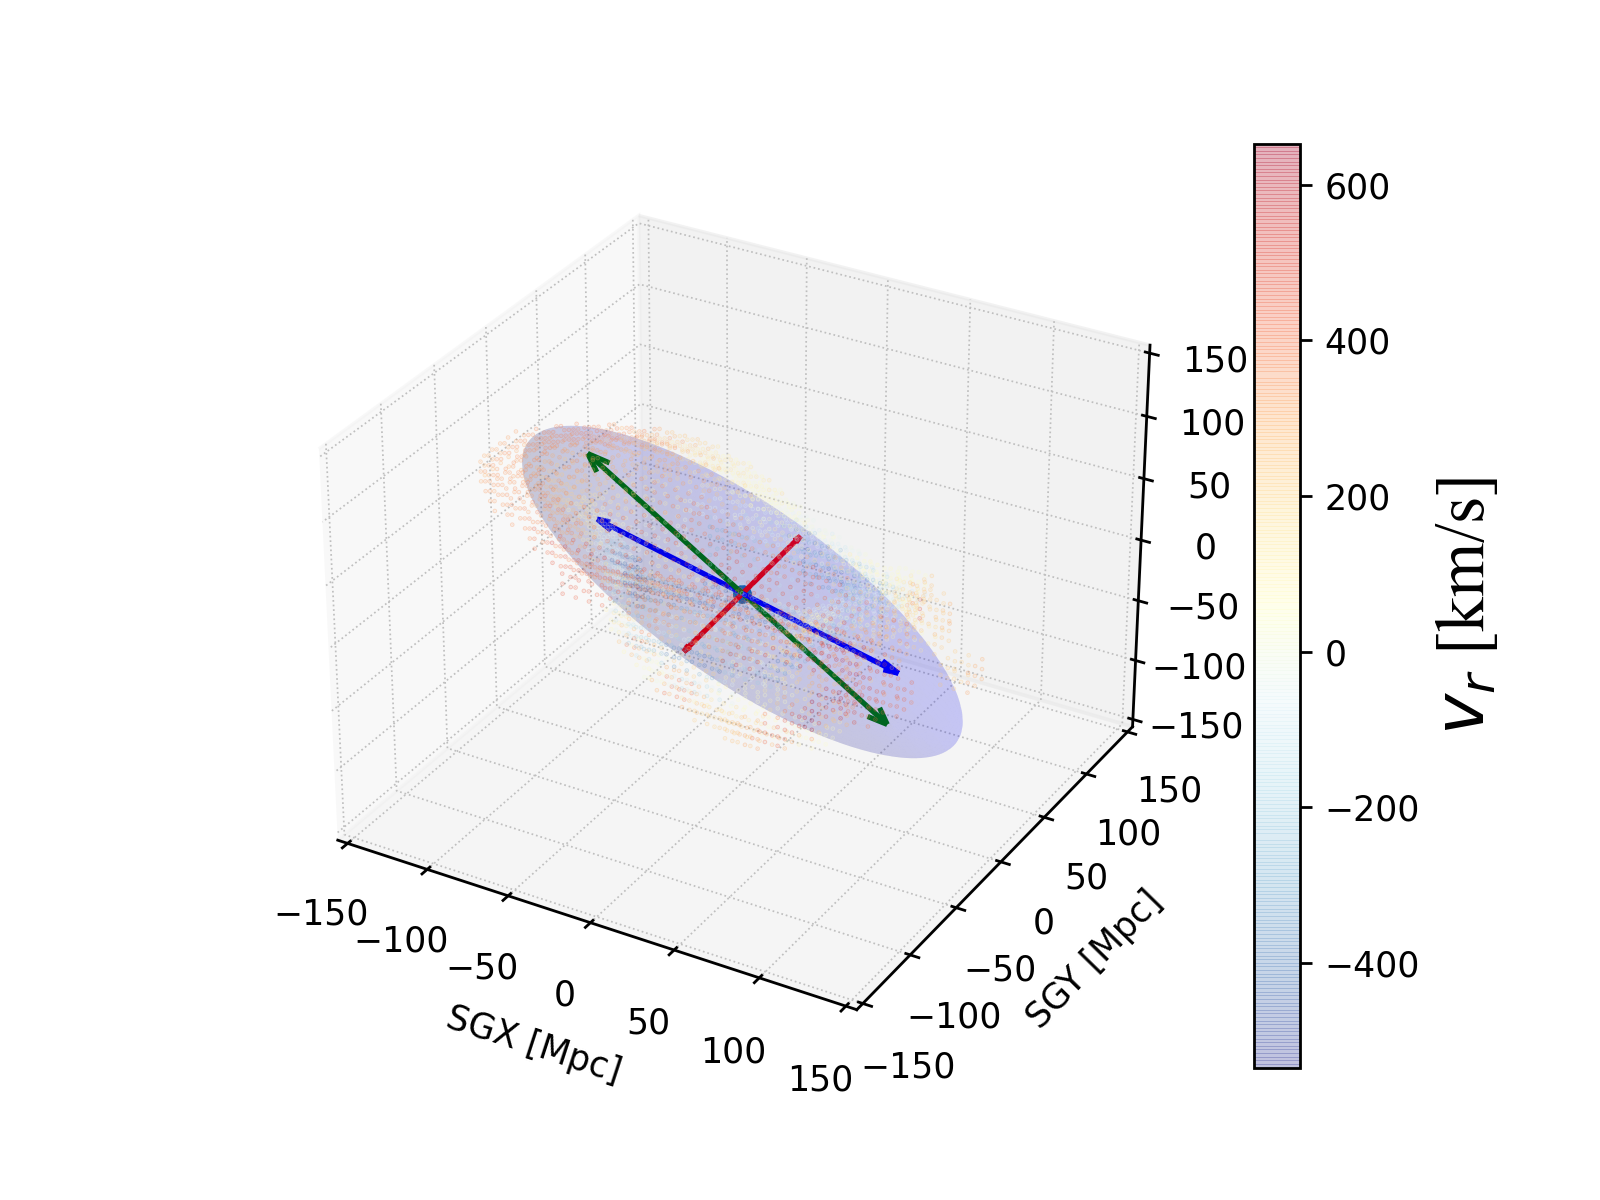

In [30]:
# Center of the ellipsoid
#center = center

center = center2
# Axes of the ellipsoid (semi-major axis length)
#axes = axes

axes = axes2
# Rotation matrix
#R = inve#*inve.T

R= R2
# Generate points on the ellipsoid
uu = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = axes[0] * np.outer(np.cos(uu), np.sin(vv))
y = axes[1] * np.outer(np.sin(uu), np.sin(vv))
z = axes[2] * np.outer(np.ones_like(uu), np.cos(vv))

# Transform the points using the rotation matrix
for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center

        
semiaxea= np.dot([axes[0], 0, 0], R)
semiaxeb= np.dot([ 0, axes[1], 0], R)
semiaxec= np.dot([ 0, 0,axes[2]], R)
# data = np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
# cov_matrix = np.cov(data, rowvar=False)

# # calculate the eigenvalues and eigenvectors
# eigenvalues, eigenvectors = eig(cov_matrix)

# # sort the eigenvalues in descending order
# sort_indices = np.argsort(eigenvalues)[::-1]
# eigenvalues = eigenvalues[sort_indices]
# eigenvectors = eigenvectors[:,sort_indices]

# # calculate the top ends of the three axes
# axis_ends = eigenvectors * np.sqrt(eigenvalues)

# print(axis_ends + center)

# Plot the ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-150.,150.)
ax.set_ylim(-150.,150.)
ax.set_zlim(-150.,150.)
# d00 = plt.contourf(xi,yi,zi,400,cmap=plt.cm.magma)#RdYlBu_r,vmax=600.,vmin=-600.
# cbar00 = plt.colorbar(d00)
# cbar00.set_label(r'$\delta_g$', fontname = 'Times New Roman',size=20)
d01 = ax.scatter(lania_cf4_wo_bf_c_vr.SGX,lania_cf4_wo_bf_c_vr.SGY,lania_cf4_wo_bf_c_vr.SGZ,c=lania_cf4_wo_bf_c_vr.vr,s=0.1,alpha=0.3,cmap=plt.cm.RdYlBu_r)
cbar01 = plt.colorbar(d01)
cbar01.set_label(r'$v_r$ [km/s]', fontname = 'Times New Roman',size=20)
ax.plot_surface(x, y, z, color='blue', alpha=0.1)
ax.scatter(center[0],center[1],center[2])
#ax.scatter(0,0,0,color="red",marker='*',s=100)

ax.quiver(center[0], center[1], center[2], semiaxea[0]*-1.0, semiaxea[1]*-1.0, semiaxea[2]*-1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*-1.0, semiaxeb[1]*-1.0, semiaxeb[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*-1.0, semiaxec[1]*-1.0, semiaxec[2]*-1.0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxea[0]*1.0, semiaxea[1]*1.0, semiaxea[2]*1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*1.0, semiaxeb[1]*1.0, semiaxeb[2]*1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*1.0, semiaxec[1]*1.0, semiaxec[2]*1.0, color='g', length=1.0, arrow_length_ratio=0.1)

# ax.quiver(center[0], center[1], center[2], list(axes[0]*-1.0*R[:,0])[0],list(axes[0]*-1.0*R[:,0])[1],list(axes[0]*-1.0*R[:,0])[2], color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[1]*-1.0*R[:,1])[0],list(axes[1]*-1.0*R[:,1])[1],list(axes[1]*-1.0*R[:,1])[2], color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[2]*-1.0*R[:,2])[0],list(axes[2]*-1.0*R[:,2])[1],list(axes[2]*-1.0*R[:,2])[2], color='r', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[0]*R[:,0])[0],list(axes[0]*R[:,0])[1],list(axes[0]*R[:,0])[2], color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[1]*R[:,1])[0],list(axes[1]*R[:,1])[1],list(axes[1]*R[:,1])[2], color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[2]*R[:,2])[0],list(axes[2]*R[:,2])[1],list(axes[2]*R[:,2])[2], color='r', length=1.0, arrow_length_ratio=0.1)

# ax.quiver(center[0], center[1], center[2], 5.98467111, -80.81276373,  -1.43559173, color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], -96.01530875,  -6.64089297, -26.43587921, color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], -35.97402395,  -5.007501,   131.91584314, color='r', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], -5.98467111, 80.81276373,  1.43559173, color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], 96.01530875,  6.64089297, 26.43587921, color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], 35.97402395,  5.007501,   -131.91584314, color='r', length=1.0, arrow_length_ratio=0.1)

#ax.grid(False)
#ax.axis('off') # Remove the axes
ax.xaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
#ax.grid(b=True, color='0.05',linestyle=':')
# Create cubic bounding box to simulate equal aspect ratio
X = lania_cf4_wo_bf_c_vr.SGX
Y = lania_cf4_wo_bf_c_vr.SGY
Z = lania_cf4_wo_bf_c_vr.SGZ
# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# # Comment or uncomment following both lines to test the fake bounding box:
# for xb, yb, zb in zip(Xb, Yb, Zb):
#    ax.plot([xb], [yb], [zb], 'w')
plt.xlabel("SGX [Mpc]")
plt.ylabel("SGY [Mpc]")
ax.set_zlabel("SGZ [Mpc]")
plt.savefig('new_ellipsoid.png', dpi=300)
plt.show()

In [31]:
semiaxea= np.dot([axes[0], 0, 0], R)
semiaxeb= np.dot([ 0, axes[1], 0], R)
semiaxec= np.dot([ 0, 0,axes[2]], R)
print (semiaxea[0]*-1.0, semiaxea[1]*-1.0, semiaxea[2]*-1.0,)

-12.619213179309003 -39.585892930338744 -25.242154807024786


In [32]:
print (list(axes[0]*-1.0*R[:,0])[0],list(axes[1]*-1.0*R[:,0])[0],list(axes[0]*-1.0*R[:,0])[2])

-12.619213179309003 -33.419001394271945 13.934307605083509


In [33]:
data = np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
print (data)
print ((axes[2]*R[:,2]))
edgex = list(axes[0]*R[:,0])[0]
edgey = list(axes[0]*R[:,0])[1]
edgez = list(axes[0]*R[:,0])[2]
print (data[:,0])

[[ -47.68996968  -74.61826728  140.86121649]
 [ -47.26557825  -73.32472156  141.59118025]
 [ -46.79359438  -71.95734407  142.17857369]
 ...
 [  48.39431431   76.97872906 -138.97666089]
 [  48.06634136   75.83667872 -139.98941743]
 [  47.68996968   74.61826728 -140.86121649]]
[ 86.39091597  19.46352119 140.86121649]
[-47.68996968 -47.26557825 -46.79359438 ...  48.39431431  48.06634136
  47.68996968]


In [34]:
diff01 = np.sqrt((data[:,0] - edgex)**2. + (data[:,1] - edgey)**2. + (data[:,2] - edgez)**2)
print (np.min(diff01),np.max(diff01))

15.083851019875176 204.90947019592136


In [35]:
print (center[0], center[1], center[2])

-2.8945187867109407e-13 2.0671393149772162e-13 3.992092552546283e-13


In [36]:
print (axes[0]*-1.0*R[:,0])
print (np.sqrt((list(axes[0]*-1.0*R[:,0])[0])**2.+(list(axes[0]*-1.0*R[:,0])[1])**2.+(list(axes[0]*-1.0*R[:,0])[2])**2.))
print (axes[0])

[-12.61921318 -44.83351838  13.93430761]
48.61536629152242
48.61536629152241


In [37]:
cov = np.diag(axes**2)
eigvals, eigvecs = np.linalg.eig(cov)
principal_axes = eigvecs

principal_axes_lengths = np.sqrt(eigvals)[:, np.newaxis] * principal_axes

rotated_principal_axes = np.dot(principal_axes_lengths, R)

data_points = np.vstack([center + rotated_principal_axes, center - rotated_principal_axes])
print (data_points)

[[  12.61921318   39.58589293   25.24215481]
 [ 118.73096934  -47.45256738   15.06055411]
 [ -47.68996968  -74.61826728  140.86121649]
 [ -12.61921318  -39.58589293  -25.24215481]
 [-118.73096934   47.45256738  -15.06055411]
 [  47.68996968   74.61826728 -140.86121649]]


In [38]:
print (axes[0]*-1.0*R[:,0])

[-12.61921318 -44.83351838  13.93430761]


Here I perform a transformation of the principal axes by scaling, rotating, and translating them in the data coordinate system. It computes the resulting data points. Again here are the steps in details:
1. I calculate the covariance matrix cov by taking the square of the axes array and creating a diagonal matrix using np.diag.
2. I compute the eigenvalues and eigenvectors of the covariance matrix using np.linalg.eig.
3. The eigenvectors are assigned to the variable principal_axes.
4. It scales the principal axes by multiplying the square root of the eigenvalues with the principal_axes array and storing the result in principal_axes_lengths.
5. It transforms the principal axes to the data coordinate system by performing a dot product between principal_axes_lengths and the transpose of the rotation matrix R, resulting in rotated_principal_axes.
6. It adds the center value to rotated_principal_axes to obtain the data points and stacks them vertically with the subtracted version of rotated_principal_axes, resulting in the data_points array.

In [39]:
# sgx_cap_c = data_points[:,0]
# sgy_cap_c = data_points[:,1]
# sgz_cap_c = data_points[:,2]
# sgx_cap = sgx_cap_c + sgx_c
# sgy_cap = sgy_cap_c + sgy_c
# sgz_cap = sgz_cap_c + sgz_c
# ii_cap = np.rint(np.round(32. + ((64./1000.)*sgx_cap),0)).astype(int)
# jj_cap = np.rint(np.round(32. + ((64./1000.)*sgy_cap),0)).astype(int)
# kk_cap = np.rint(np.round(32. + ((64./1000.)*sgz_cap),0)).astype(int)
# lania_vv_cap = t[:,kk_cap,jj_cap,ii_cap]
# lania_vv_cap_err = t_e[kk_cap,jj_cap,ii_cap]
# print (lania_vv_cap)
# print (lania_vv_cap_err)

compute_lania_vv_cap is the function that takes sgx_cap_c, sgy_cap_c, and sgz_cap_c as inputs. It performs the necessary calculations to compute ii_cap, jj_cap, kk_cap, lania_vv_cap, and lania_vv_cap_err based on the provided formulas. Finally, the function returns lania_vv_cap and lania_vv_cap_err. the compute_lania_vv_cap function includes an additional parameter add_center which is set to True by default. If add_center is True, the center values sgx_c, sgy_c, and sgz_c are added to sgx_cap_c, sgy_cap_c, and sgz_cap_c respectively. If add_center is False, the center values are not added, and sgx_cap, sgy_cap, and sgz_cap are assigned the values of sgx_cap_c, sgy_cap_c, and sgz_cap_c respectively.

In [40]:
def compute_lania_vv_cap(sgx_cap_c, sgy_cap_c, sgz_cap_c, add_center=True):
    if add_center:
        sgx_cap = sgx_cap_c + sgx_c
        sgy_cap = sgy_cap_c + sgy_c
        sgz_cap = sgz_cap_c + sgz_c
    else:
        sgx_cap = sgx_cap_c
        sgy_cap = sgy_cap_c
        sgz_cap = sgz_cap_c

    ii_cap = np.rint(np.round(32. + ((64./1000.)*sgx_cap), 0)).astype(int)
    jj_cap = np.rint(np.round(32. + ((64./1000.)*sgy_cap), 0)).astype(int)
    kk_cap = np.rint(np.round(32. + ((64./1000.)*sgz_cap), 0)).astype(int)

    lania_vv_cap = t[:, kk_cap, jj_cap, ii_cap]
    lania_vv_cap_err = t_e[kk_cap, jj_cap, ii_cap]

    return lania_vv_cap, lania_vv_cap_err

sgx_cap_c = data_points[:, 0]
sgy_cap_c = data_points[:, 1]
sgz_cap_c = data_points[:, 2]

lania_vv_cap, lania_vv_cap_err = compute_lania_vv_cap(sgx_cap_c, sgy_cap_c, sgz_cap_c, add_center=True)

print (lania_vv_cap)
print (lania_vv_cap_err)

[[-179.2316   -101.12771   306.12598   189.74333  -218.50671  -355.41858 ]
 [-106.524666   80.20801  -161.19835    16.908516   44.55964    99.12266 ]
 [-395.8982     62.831326 -158.34319  -355.87677  -221.41165   -72.43659 ]]
[119.79274761 193.28965409 151.61625869  95.49413466 134.98233605
 102.02882522]


In [41]:
sgx_cap_c

array([  12.61921318,  118.73096934,  -47.68996968,  -12.61921318,
       -118.73096934,   47.68996968])

In [42]:
print (list(axes[0]*-1.0*R[:,0]))

[-12.619213179309003, -44.833518375886584, 13.934307605083509]


In [43]:
lania_cf4_wo_bf_c_cap = pd.DataFrame(np.column_stack((sgx_cap_c,sgy_cap_c,sgz_cap_c,lania_vv_cap[2]-sgx_bf,lania_vv_cap[1]-sgy_bf,lania_vv_cap[0]-sgz_bf)),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4_wo_bf_c_cap

,SGX,SGY,SGZ,vx,vy,vz
0,12.619213,39.585893,25.242155,-231.696091,-126.071609,-83.210739
1,118.730969,-47.452567,15.060554,227.033432,60.661064,-5.106850
2,-47.689970,-74.618267,140.861216,5.858917,-180.745300,402.146851
3,-12.619213,-39.585893,-25.242155,-191.674667,-2.638428,285.764191
4,-118.730969,47.452567,-15.060554,-57.209549,25.012695,-122.485855
5,47.689970,74.618267,-140.861216,91.765511,79.575714,-259.397705


In [44]:
vr_cap = (lania_cf4_wo_bf_c_cap.SGX*lania_cf4_wo_bf_c_cap.vx+lania_cf4_wo_bf_c_cap.SGY*lania_cf4_wo_bf_c_cap.vy+lania_cf4_wo_bf_c_cap.SGZ*lania_cf4_wo_bf_c_cap.vz)/np.sqrt(lania_cf4_wo_bf_c_cap.SGX**2+lania_cf4_wo_bf_c_cap.SGY**2+lania_cf4_wo_bf_c_cap.SGZ**2)

In [45]:
lania_cf4_wo_bf_c_cap_vr = pd.DataFrame(np.column_stack((lania_cf4_wo_bf_c_cap,vr_cap,lania_vv_cap_err)),columns=["SGX","SGY","SGZ","vx","vy","vz","vr","err"])
lania_cf4_wo_bf_c_cap_vr

,SGX,SGY,SGZ,vx,vy,vz,vr,err
0,12.619213,39.585893,25.242155,-231.696091,-126.071609,-83.210739,-206.002725,119.792748
1,118.730969,-47.452567,15.060554,227.033432,60.661064,-5.106850,186.416731,193.289654
2,-47.689970,-74.618267,140.861216,5.858917,-180.745300,402.146851,419.834818,151.616259
3,-12.619213,-39.585893,-25.242155,-191.674667,-2.638428,285.764191,-96.473117,95.494135
4,-118.730969,47.452567,-15.060554,-57.209549,25.012695,-122.485855,76.306401,134.982336
5,47.689970,74.618267,-140.861216,91.765511,79.575714,-259.397705,281.594254,102.028825


<IPython.core.display.Javascript object>


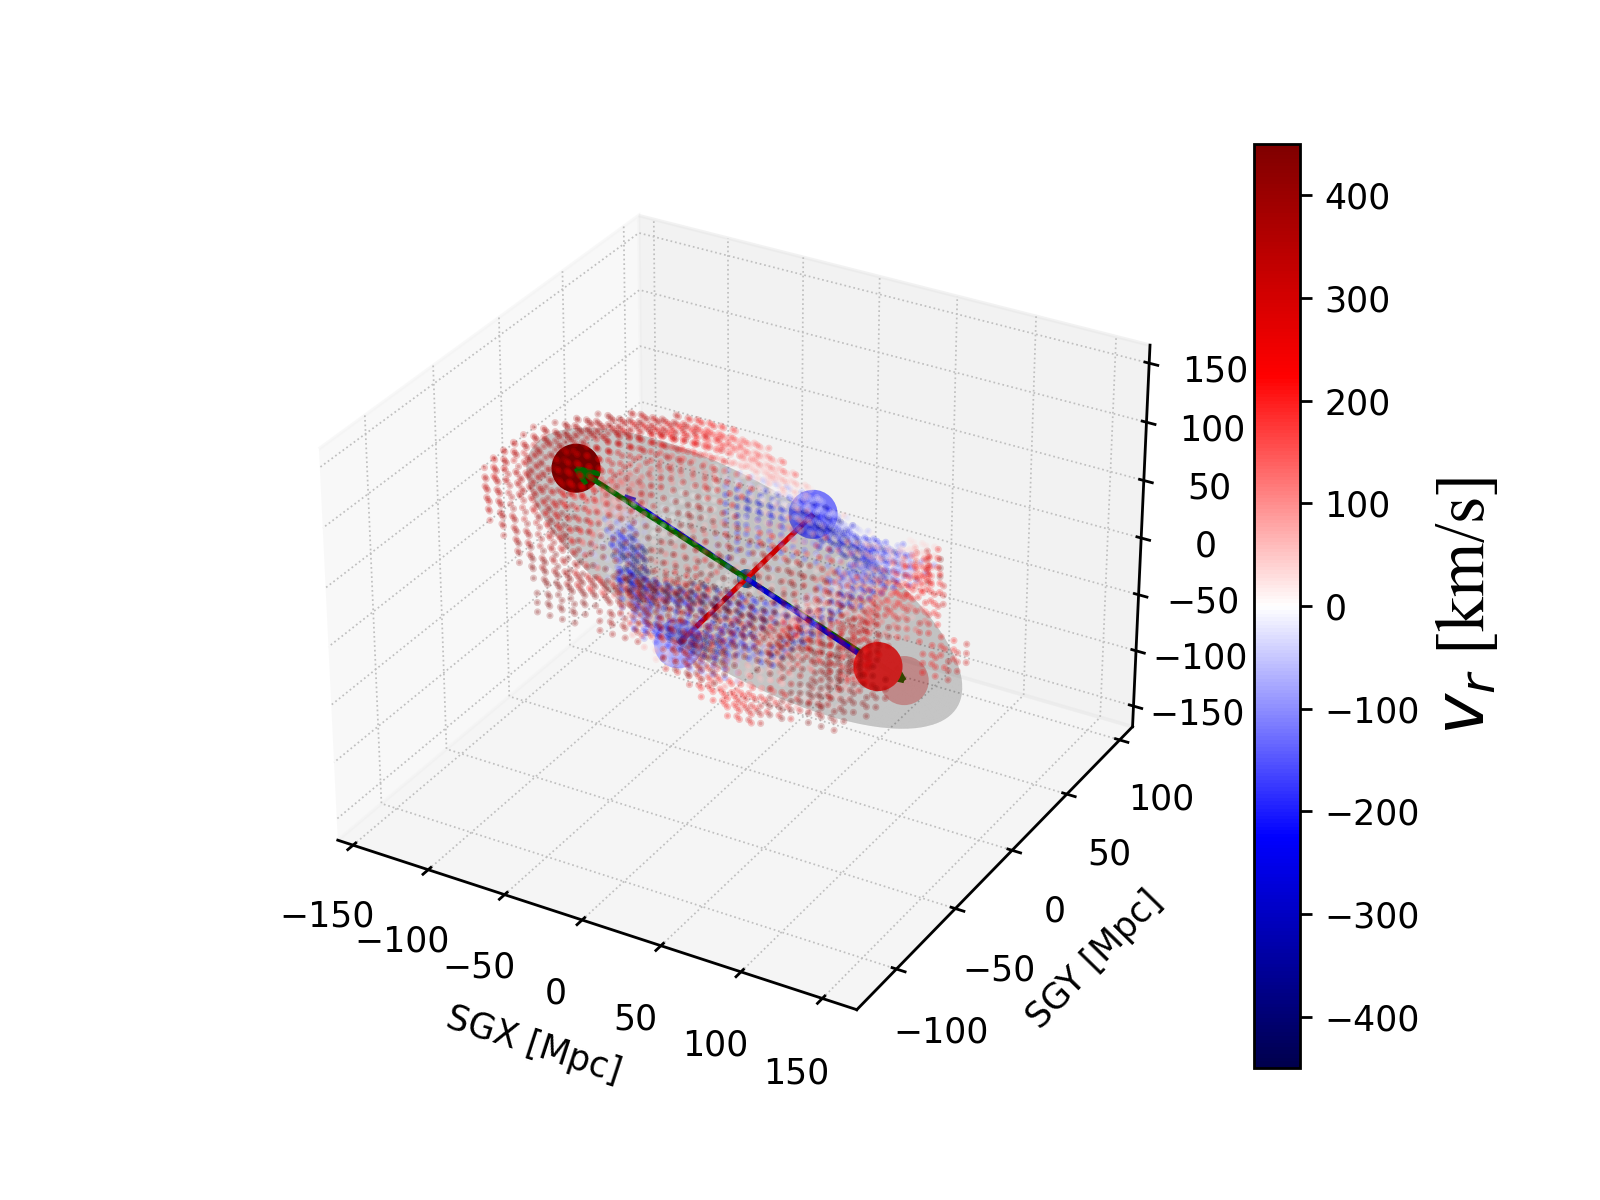

In [46]:
# Plot the ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

d02 = ax.scatter(lania_cf4_wo_bf_c_cap_vr.SGX,lania_cf4_wo_bf_c_cap_vr.SGY,lania_cf4_wo_bf_c_cap_vr.SGZ,c=lania_cf4_wo_bf_c_cap_vr.vr,edgecolor="none",s=200,cmap=plt.cm.seismic, vmin = -450, vmax =450)
cbar02 = plt.colorbar(d02)
cbar02.set_label(r'$v_r$ [km/s]', fontname = 'Times New Roman',size=20)

ax.scatter(lania_cf4_wo_bf_c_vr.SGX,lania_cf4_wo_bf_c_vr.SGY,lania_cf4_wo_bf_c_vr.SGZ,c=lania_cf4_wo_bf_c_vr.vr,s=1.1,alpha=0.2,cmap=plt.cm.seismic, vmin = -450, vmax =450)
#ax.scatter(df_new.SGX,df_new.SGX,df_new.SGX,color='b')
ax.plot_surface(x, y, z, color='black', alpha=0.1)
ax.scatter(center[0],center[1],center[2])
#ax.scatter(0,0,0,color="red",marker='*',s=100)

ax.quiver(center[0], center[1], center[2], semiaxea[0]*-1.0, semiaxea[1]*-1.0, semiaxea[2]*-1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*-1.0, semiaxeb[1]*-1.0, semiaxeb[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*-1.0, semiaxec[1]*-1.0, semiaxec[2]*-1.0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxea[0]*1.0, semiaxea[1]*1.0, semiaxea[2]*1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*1.0, semiaxeb[1]*1.0, semiaxeb[2]*1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*1.0, semiaxec[1]*1.0, semiaxec[2]*1.0, color='g', length=1.0, arrow_length_ratio=0.1)

# ax.quiver(center[0], center[1], center[2], list(axes[0]*-1.0*R[:,0])[0],list(axes[0]*-1.0*R[:,0])[1],list(axes[0]*-1.0*R[:,0])[2], color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[1]*-1.0*R[:,1])[0],list(axes[1]*-1.0*R[:,1])[1],list(axes[1]*-1.0*R[:,1])[2], color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[2]*-1.0*R[:,2])[0],list(axes[2]*-1.0*R[:,2])[1],list(axes[2]*-1.0*R[:,2])[2], color='r', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[0]*R[:,0])[0],list(axes[0]*R[:,0])[1],list(axes[0]*R[:,0])[2], color='b', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[1]*R[:,1])[0],list(axes[1]*R[:,1])[1],list(axes[1]*R[:,1])[2], color='g', length=1.0, arrow_length_ratio=0.1)
# ax.quiver(center[0], center[1], center[2], list(axes[2]*R[:,2])[0],list(axes[2]*R[:,2])[1],list(axes[2]*R[:,2])[2], color='r', length=1.0, arrow_length_ratio=0.1)

#ax.grid(False)
#ax.axis('off') # Remove the axes
ax.xaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
#ax.grid(b=True, color='0.05',linestyle=':')
# Create cubic bounding box to simulate equal aspect ratio
X = lania_cf4_wo_bf_c_vr.SGX
Y = lania_cf4_wo_bf_c_vr.SGY
Z = lania_cf4_wo_bf_c_vr.SGZ

plt.xlabel("SGX [Mpc]")
plt.ylabel("SGY [Mpc]")
ax.set_zlabel("SGZ [Mpc]")
plt.savefig('new_caps.png', dpi=300)
plt.show()

In [47]:
print (axes[0])
print (R[:,0])
print (R)

48.61536629152241
[ 0.25957252  0.9222088  -0.28662352]
[[ 0.25957252  0.81426709  0.51922173]
 [ 0.9222088  -0.36857422  0.11697854]
 [-0.28662352 -0.44846644  0.84659601]]


In [48]:
lania_cf4_wo_bf_c_cap_vr.to_csv("new_lania_cf4_wo_bf_c_cap_vr.csv", index = False, header = True)

The below function "get_neighboring_cells" takes a point (in the form of [x, y, z] coordinates) and computes the neighboring cell coordinates based on the given offsets. The function returns a list of neighboring cell coordinates.

You can provide your own ellipsoid cap points in the caps list, and the code will print the neighboring cells for each cap. Adjust the resolution value (currently set to 16) according to the cf4 grid resolution in Mpc/h

In [49]:
def get_neighboring_cells(point):
    x, y, z = point

    offsets = np.array([
        [1, 0, 0],  # Right
        [-1, 0, 0],  # Left
        [0, 1, 0],  # Up
        [0, -1, 0],  # Down
        [0, 0, 1],  # Front
        [0, 0, -1]  # Back
    ])

    neighboring_cells = []
    for offset in offsets:
        neighboring_cell = [x, y, z] + offset * 16  # Assuming 16 Mpc resolution
        neighboring_cells.append(neighboring_cell)

    return neighboring_cells

results = []
for _, row in lania_cf4_wo_bf_c_cap.iterrows():
    point = row['SGX'], row['SGY'], row['SGZ']
    neighboring_cells = get_neighboring_cells(point)

    lania_vv_cap_point, lania_vv_cap_err_point = compute_lania_vv_cap(point[0], point[1], point[2], add_center=True)

    results.append([point[0], point[1], point[2], lania_vv_cap_point[2]-sgx_bf, lania_vv_cap_point[1]-sgy_bf, lania_vv_cap_point[0]-sgz_bf, lania_vv_cap_err_point])

    for cell in neighboring_cells:
        lania_vv_cap_cell, lania_vv_cap_err_cell = compute_lania_vv_cap(cell[0], cell[1], cell[2], add_center=True)
        results.append([cell[0], cell[1], cell[2], lania_vv_cap_cell[2]-sgx_bf, lania_vv_cap_cell[1]-sgy_bf, lania_vv_cap_cell[0]-sgz_bf, lania_vv_cap_err_cell])

lania_cf4_wo_bf_c_cap_neighboring = pd.DataFrame(results, columns=["SGX","SGY","SGZ","vx","vy","vz","err"])

In [50]:
vr_cap_neighboring = (lania_cf4_wo_bf_c_cap_neighboring.SGX*lania_cf4_wo_bf_c_cap_neighboring.vx+lania_cf4_wo_bf_c_cap_neighboring.SGY*lania_cf4_wo_bf_c_cap_neighboring.vy+lania_cf4_wo_bf_c_cap_neighboring.SGZ*lania_cf4_wo_bf_c_cap_neighboring.vz)/np.sqrt(lania_cf4_wo_bf_c_cap_neighboring.SGX**2+lania_cf4_wo_bf_c_cap_neighboring.SGY**2+lania_cf4_wo_bf_c_cap_neighboring.SGZ**2)
lania_cf4_wo_bf_c_cap_vr_neighboring = pd.DataFrame(np.column_stack((lania_cf4_wo_bf_c_cap_neighboring.iloc[:,:6],vr_cap_neighboring,lania_cf4_wo_bf_c_cap_neighboring["err"])),columns=["SGX","SGY","SGZ","vx","vy","vz","vr","err"])
lania_cf4_wo_bf_c_cap_vr_neighboring
lania_cf4_wo_bf_c_cap_vr_neighboring.to_csv("lania_cf4_wo_bf_c_cap_vr_neighboring.csv", index = False, header = True)

<IPython.core.display.Javascript object>


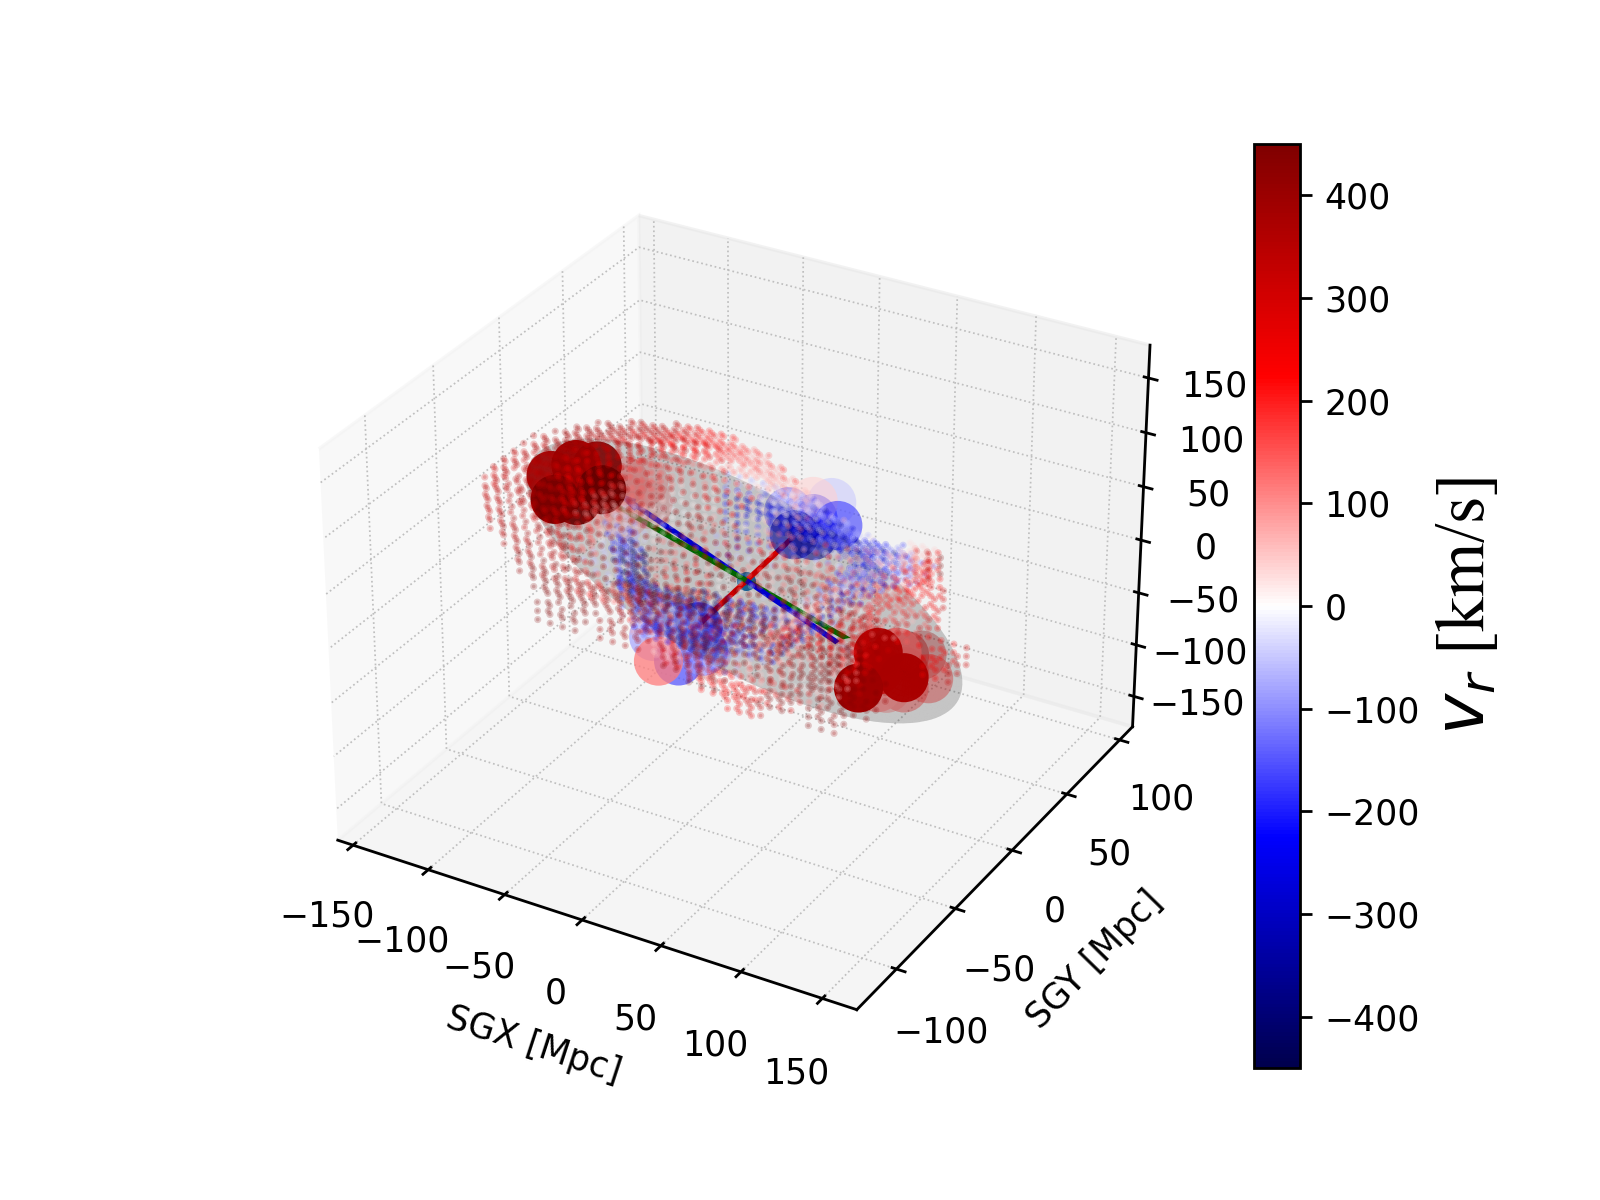

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

d02 = ax.scatter(lania_cf4_wo_bf_c_cap_vr_neighboring.SGX,lania_cf4_wo_bf_c_cap_vr_neighboring.SGY,lania_cf4_wo_bf_c_cap_vr_neighboring.SGZ,c=lania_cf4_wo_bf_c_cap_vr_neighboring.vr,edgecolor="none",s=200,cmap=plt.cm.seismic, vmin = -450, vmax =450)
cbar02 = plt.colorbar(d02)
cbar02.set_label(r'$v_r$ [km/s]', fontname = 'Times New Roman',size=20)

ax.scatter(lania_cf4_wo_bf_c_vr.SGX,lania_cf4_wo_bf_c_vr.SGY,lania_cf4_wo_bf_c_vr.SGZ,c=lania_cf4_wo_bf_c_vr.vr,s=1.1,alpha=0.2,cmap=plt.cm.seismic, vmin = -450, vmax =450)
ax.plot_surface(x, y, z, color='black', alpha=0.1)
ax.scatter(center[0],center[1],center[2])

ax.quiver(center[0], center[1], center[2], semiaxea[0]*-1.0, semiaxea[1]*-1.0, semiaxea[2]*-1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*-1.0, semiaxeb[1]*-1.0, semiaxeb[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*-1.0, semiaxec[1]*-1.0, semiaxec[2]*-1.0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxea[0]*1.0, semiaxea[1]*1.0, semiaxea[2]*1.0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxeb[0]*1.0, semiaxeb[1]*1.0, semiaxeb[2]*1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], semiaxec[0]*1.0, semiaxec[1]*1.0, semiaxec[2]*1.0, color='g', length=1.0, arrow_length_ratio=0.1)

ax.xaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":0.5, "color" : "0.75","linestyle" :":"})

X = lania_cf4_wo_bf_c_vr.SGX
Y = lania_cf4_wo_bf_c_vr.SGY
Z = lania_cf4_wo_bf_c_vr.SGZ

plt.xlabel("SGX [Mpc]")
plt.ylabel("SGY [Mpc]")
ax.set_zlabel("SGZ [Mpc]")
plt.savefig('new_cap_neighboring.png', dpi=300)
plt.show()

Ellipsoids:


<IPython.core.display.Javascript object>


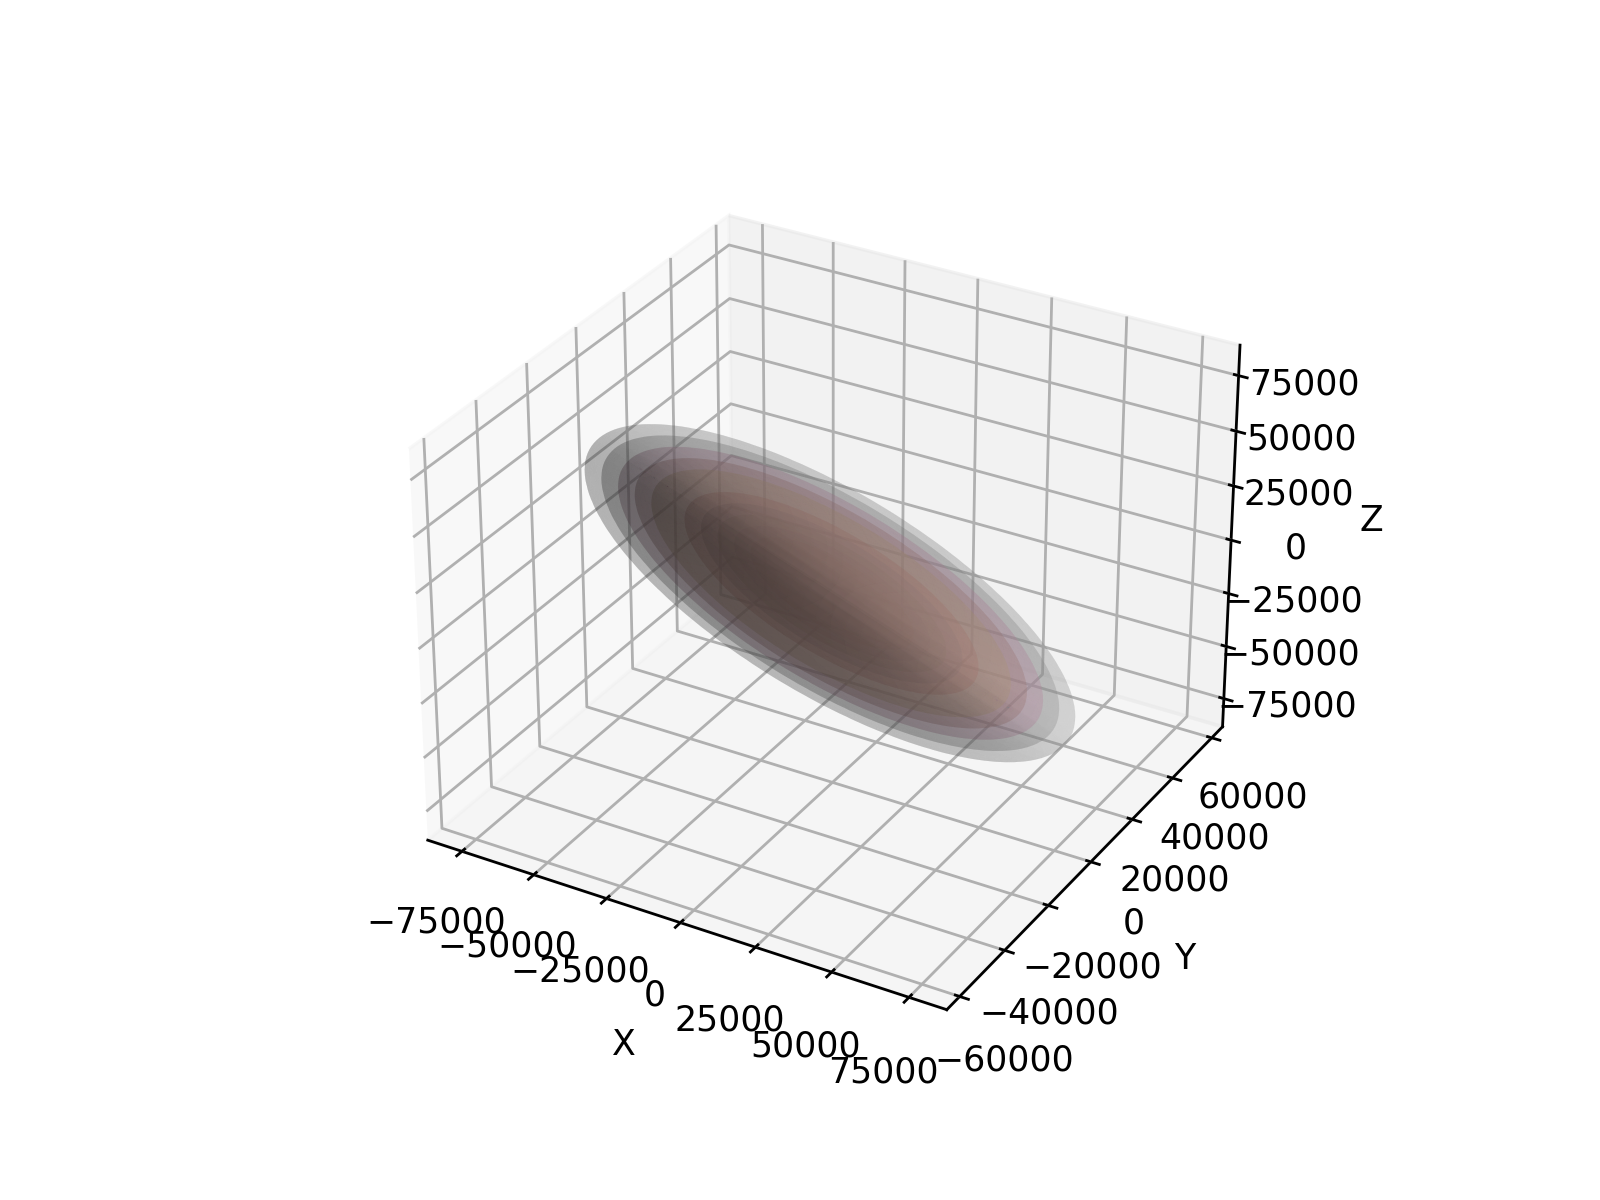

Ellipsoid 1:
Center: [-2.89451879e-13  2.06713931e-13  3.99209255e-13]
Axes: [17243.58122093 45665.54639153 59015.9115859 ]
Rotation Matrix:
[[ 0.25957252  0.81426709  0.51922173]
 [ 0.9222088  -0.36857422  0.11697854]
 [-0.28662352 -0.44846644  0.84659601]]

Ellipsoid 2:
Center: [-2.89451879e-13  2.06713931e-13  3.99209255e-13]
Axes: [15327.62775193 40591.59679247 52458.58807636]
Rotation Matrix:
[[ 0.25957252  0.81426709  0.51922173]
 [ 0.9222088  -0.36857422  0.11697854]
 [-0.28662352 -0.44846644  0.84659601]]

Ellipsoid 3:
Center: [-2.89451879e-13  2.06713931e-13  3.99209255e-13]
Axes: [13411.67428294 35517.64719341 45901.26456681]
Rotation Matrix:
[[ 0.25957252  0.81426709  0.51922173]
 [ 0.9222088  -0.36857422  0.11697854]
 [-0.28662352 -0.44846644  0.84659601]]

Ellipsoid 4:
Center: [-2.89451879e-13  2.06713931e-13  3.99209255e-13]
Axes: [11495.72081395 30443.69759435 39343.94105727]
Rotation Matrix:
[[ 0.25957252  0.81426709  0.51922173]
 [ 0.9222088  -0.36857422  0.11697854]
 

In [68]:
def generate_ellipsoids(center, axes, R, scale_factor):
    ellipsoids = []

    for factor in np.linspace(0.9, 0.5, 5):
        smaller_axes = axes * factor
        ellipsoids.append((center, smaller_axes, R))

    for factor in np.linspace(1.1, 1.5, 5):
        larger_axes = axes * factor
        ellipsoids.append((center, larger_axes, R))

    return ellipsoids


def plot_ellipsoid(center, axes, R, color):
    uu = np.linspace(0, 2 * np.pi, 100)
    vv = np.linspace(0, np.pi, 100)
    x = axes[0] * np.outer(np.cos(uu), np.sin(vv))
    y = axes[1] * np.outer(np.sin(uu), np.sin(vv))
    z = axes[2] * np.outer(np.ones_like(uu), np.cos(vv))

    # Transform the points using the rotation matrix
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center

    ax.plot_surface(x, y, z, color=color, alpha=0.2)


center = center
axes = axes
R = R
scale_factor = 1.0

# Generate ellipsoids
ellipsoids = generate_ellipsoids(center, axes, R, scale_factor)

# Print ellipsoids
print("Ellipsoids:")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, ellipsoid in enumerate(ellipsoids):
    center, axes, R = ellipsoid
    print(f"Ellipsoid {i + 1}:")
    print("Center:", center)
    print("Axes:", axes)
    print("Rotation Matrix:")
    print(R)
    print()
    # Plot ellipsoid
    color = plt.cm.Set1(i)
    plot_ellipsoid(center, axes, R, color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()